# Metadata

- Title: Final Project Report
- Class: DS5100
- Date: June 15, 2022
- Student Name: Gunnar Franko
- Student ID: gbf6qz 
- This URL: https://github.com/gbfranko/MonteCarlo-Project/blob/main/5100Final.ipynb
- GitHub Repo URL: https://github.com/gbfranko/MonteCarlo-Project

# The Monte Carlo Module

In [1]:
import pandas as pd
import numpy as np


class Die:
    '''
    A die has N sides, or “faces”, and W weights, and can be rolled to select a face. 
    W defaults to 1.0 for each face but can be changed after the object is created.
    The die has one behavior, which is to be rolled one or more times.
    '''
    def __init__(self, N):
        '''
        Takes an array of faces as an argument. The array's data type (dtype) may be strings or numbers.
        Internally iInitializes the weights to 1.0 for each face.
        Saves both faces and weights into a private dataframe that is to be shared by the other methods.

        '''
        self.faces = N
        self.weights = np.ones(len(N))
        self._diedf = pd.DataFrame({'faces':self.faces, 'weights':self.weights})
        
    def change_weight(self, face, weight):
        '''
        Takes two arguments: the face value to be changed and the new weight.
        Checks to see if the face passed is valid; is it in the array of weights?
        Checks to see if the weight is valid; is it a float? Can it be converted to one?

        '''
        if type(weight) != float:
            print('Weight is not a float')
        elif any(face == self._diedf['faces']):
            self._diedf.loc[self._diedf['faces']==face, 'weights']= weight
        else:
            print('Face does not exist')
    
    def roll(self, times=1):
        '''
        Takes a parameter of how many times the die is to be rolled; defaults to 1. 
        This is essentially a random sample from the vector of faces according to the weights.
        Returns a list of outcomes.
        Does not store internally these results. 

        '''
        return(self._diedf['faces'].sample(times,replace=True,
                                           weights=self._diedf['weights']/sum(self._diedf['weights'])))
    
    def show(self):
        '''
        Returns the dataframe created in the initializer.

        '''
        return(self._diedf)
        
            


class Game(Die):
    '''
    A game consists of rolling of one or more dice of the same kind one or more times. 
    Each game is initialized with one or more of similarly defined dice (Die objects).
    By “same kind” and “similarly defined” we mean that each die in a given game has 
    the same number of sides and associated faces, but each die object may have its own weights.
    The class has a behavior to play a game, i.e. to rolls all of the dice a given number of times.
    The class keeps the results of its most recent play. 
    '''
    def __init__(self, dies):
        '''
        Takes a single parameter, a list of already instantiated similar Die objects.

        '''
        self.dies = dies
     
    def play(self, nrolls):
        '''
        Takes a parameter to specify how many times the dice should be rolled.
        Saves the result of the play to a private dataframe of shape N rolls by M dice.
        The private dataframe should have the roll number is a named index.

        '''
        self._playdf= pd.DataFrame()
        counter = 0
        for i in self.dies:
            counter += 1
            self._playdf['Die '+str(counter)]=(i.roll(nrolls)).tolist()
        dexcount = 0
        self.playdex = []
        for i in range(nrolls):
            dexcount +=1
            self.playdex.append('Roll '+str(dexcount).zfill(len(str(nrolls))))
        self._playdf.index = (self.playdex)
    
    def Gshow(self, form = 'wide'):
        '''
        This method just passes the private dataframe to the user.
        Takes a parameter to return the dataframe in narrow or wide form.
        This parameter defaults to wide form.
        This parameter should raise an exception of the user passes an invalid option.
        The narrow form of the dataframe will have a two-column index with the roll number 
        and the die number, and a column for the face rolled.
        The wide form of the dataframe will a single column index with the roll number, 
        and each die number as a column.

        '''
        form = form
        if form == 'wide':
            return(np.transpose(self._playdf))
        elif form =='narrow':
            return( self._playdf.stack())
        else:
            print('Invalid Form')



class Analyzer(Game):
    '''
    An analyzer takes the results of a single game and computes various descriptive 
    statistical properties about it. These properties results are available as attributes 
    of an Analyzer object. 

    '''
    
    def __init__(self, game):
        '''
        Takes a game object as its input parameter. 
        At initialization time, it also infers the data type of the die faces used.

        '''
        self.game = game
        self.ftype = type(self.game.dies[0]._diedf['faces'][0])
        
    def jackpot(self):
        '''
        Returns an integer for the number times to the user.
        Stores the results as a dataframe of jackpot results in a public attribute.
        The dataframe should have the roll number as a named index.

        '''
        self.jpotdf = self.game._playdf
        for row in self.game._playdf.index:
            if len(np.unique(self.game._playdf.loc[row,:])) >1 :
                self.jpotdf = self.jpotdf.drop(row)
        self.numjpot = len(self.jpotdf)
        return(int(self.numjpot))
        
    def combo(self):
        '''
        Combinations should be sorted and saved as a multi-columned index.
        Stores the results as a dataframe in a public attribute.
        '''
        self.combo = self.game._playdf.apply(lambda x: pd.Series(sorted(x)), 1).value_counts().to_frame('n')
        return(self.combo)
    
    def face_counts_per_roll(self):
        '''
        Stores the results as a dataframe in a public attribute.
        The dataframe has an index of the roll number and face values as columns (i.e. it is in wide format).
        '''
        self.fcpr = self.game._playdf.stack().groupby(level=0).value_counts().unstack(fill_value=0)
        return(self.fcpr)


# Test Module

In [2]:
import unittest
import montecarlo
import pandas


class montecarloTestSuite(unittest.TestCase):
    '''
    Includes unittests for each method in each class of the montecarlo.py
    '''
    
    def test_1_change_weight(self):
        '''
        Adds a Die, Changes weight then tests if weight is different
        '''
        d1 = montecarlo.Die(['H','T'])
        d1.change_weight('H',3.0)
        self.assertFalse(d1._diedf['weights'][0]==1.0)
        
    def test_2_roll(self):
        '''
        Sets a number of rolls for the game and makes sure that it rolls that many times
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        test2 = len(d2._playdf)
        self.assertEqual(test2, 43)
        
    def test_3_show(self):
        '''
        Runs the game then sees if the wide function works for dataframe of rolls
        '''
        d1 = montecarlo.Die(['H','T'])
        test3 = type(d1._diedf)
        self.assertEqual(test3, pandas.core.frame.DataFrame)
    
    
    def test_4_play(self):
        '''
        Runs the play and tests that it returns dataframe
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        test4 = type(d2._playdf)
        self.assertEqual(test4, pandas.core.frame.DataFrame)
        
    def test_5_play(self):
        '''
        Runs same play as test 4 and tests to see if the length of data frame is same as number of rolls 
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        test5 = len(d2._playdf)
        self.assertEqual(test5, 43)
        
    def test_6_Gshow(self):
        '''
        Runs same game and tests to see if the wide works
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        test6 = len(d2.Gshow('wide'))
        self.assertEqual(test6, 2)
        
    def test_7_Gshow(self):
        '''
        Runs same game and tests to see if the narrow works 
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        test7 = len(d2.Gshow('narrow'))
        self.assertEqual(test7, 86)
        
    def test_8_jackpot(self):
        '''
        Runs same game and tests to see if jackpot returns an int 
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        d3 = montecarlo.Analyzer(d2)
        test8 = type(d3.jackpot())
        self.assertEqual(test8, int)
        
    def test_9_combo(self):
        '''
        Runs the game and tests to see if combo dataframe has right dimensions
        '''
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        d3 = montecarlo.Analyzer(d2)   
        test9 = d3.combo().shape
        self.assertEqual(test9, (3,1))

    def test_10_face_counts_per_roll(self):
        '''
        Runs the game and tests to see if facecount dataframe has right dimensions
        '''        
        d1 = montecarlo.Die(['H','T'])
        d2 = montecarlo.Game([d1,d1])
        d2.play(43)
        d3 = montecarlo.Analyzer(d2)   
        test10 = d3.face_counts_per_roll().shape  
        self.assertEqual(test10, (43,2))
        
    def test_11_init(self):
        '''
        Tests to see if the Die class initializes 

        '''
        try:
            d1 = montecarlo.Die(['1', '2', '3', '4'])
        except RuntimeError:
            print('The Die was not created')
        
    def test_12_init(self):
        '''
        Tests to see if the Game class initializes
        '''
        try:
            d1 = montecarlo.Die(['1', '2', '3', '4'])
            d2 = montecarlo.Game([d1,d1])
        except RuntimeError:
            print('The Game was not created')
        
    def test_13_init(self):
        '''
        Tests to see if the Analyzer class initializes 
        '''
        try:
            d1 = montecarlo.Die(['1', '2', '3', '4'])
            d2 = montecarlo.Game([d1,d1])
            d2.play(43)
            d3 = montecarlo.Analyzer(d2)
        except RuntimeError:
            print('The Game was not Analyzed')
        
        
    
    
if __name__ == '__main__':
    unittest.main(verbosity=3)


/Users/gunnarfranko/Library/Jupyter/runtime/kernel-43ea4a1a-8d40-4bf9-bc13-709c10b9e2c7 (unittest.loader._FailedTest) ... ERROR

ERROR: /Users/gunnarfranko/Library/Jupyter/runtime/kernel-43ea4a1a-8d40-4bf9-bc13-709c10b9e2c7 (unittest.loader._FailedTest)
----------------------------------------------------------------------
AttributeError: module '__main__' has no attribute '/Users/gunnarfranko/Library/Jupyter/runtime/kernel-43ea4a1a-8d40-4bf9-bc13-709c10b9e2c7'

----------------------------------------------------------------------
Ran 1 test in 0.001s

FAILED (errors=1)


SystemExit: True

/Users/gunnarfranko/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3452: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Test Results 

# Scenarios

Code blocks with your scenarios and their outputs.

These should have appropriate import statements even though the code is now in the same notebook as the class it calls. 

## Scenario 1

In [3]:
import pandas as pd
import numpy as np
import os
os.chdir('/Users/gunnarfranko/Downloads/DS 5100/')
import montecarlo as FClasses

<AxesSubplot:title={'center':'Jackpot Frequencies'}, xlabel='Game', ylabel='Frequency'>

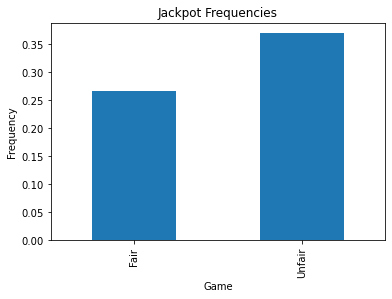

In [4]:
coin1= FClasses.Die(['H', 'T'])
coin2 = FClasses.Die(['H', 'T'])
coin2.change_weight('H', 5.0)
game1 = FClasses.Game([coin1, coin1, coin1])
game1.play(1000)
game2 = FClasses.Game([coin1, coin2, coin2])
game2.play(1000)
game1an = FClasses.Analyzer(game1)
game2an = FClasses.Analyzer(game2)
game1freq = (game1an.jackpot()/1000)
game2freq = (game2an.jackpot()/1000)
gamedf = pd.DataFrame({'Freq': [game1freq, game2freq]}, index=['Fair', 'Unfair'])
gamedf.plot.bar(title = 'Jackpot Frequencies', xlabel ='Game', ylabel='Frequency', legend = False)

## Scenario 2

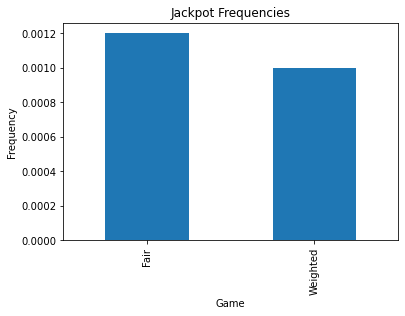

In [5]:
FDie = FClasses.Die(['1','2','3','4','5','6'])
T1Die = FClasses.Die(['1','2','3','4','5','6'])
T2Die = FClasses.Die(['1','2','3','4','5','6'])
T1Die.change_weight('6', 5.0)
T2Die.change_weight('1', 5.0)
fgame = FClasses.Game([FDie, FDie, FDie, FDie, FDie])
fgame.play(10000)
wgame = FClasses.Game([T1Die, T1Die, T2Die, FDie, FDie])
wgame.play(10000)
fgamean = FClasses.Analyzer(fgame)
wgamean = FClasses.Analyzer(wgame)
fgamefreq = (fgamean.jackpot()/10000)
wgamefreq = (wgamean.jackpot()/10000)
diegamedf = pd.DataFrame({'Freq': [fgamefreq, wgamefreq]}, index=['Fair', 'Weighted'])
diegamedf.plot.bar(title = 'Jackpot Frequencies', xlabel ='Game', ylabel='Frequency', legend = False)
fcombodf = fgamean.combo()
wcombodf = wgamean.combo()
fdf10 = fcombodf.head(10).reset_index()
wdf10 = wcombodf.head(10).reset_index()
fdf10['freq'] = fdf10['n']/10000
wdf10['freq'] = wdf10['n']/10000

<AxesSubplot:title={'center':'Fair Jackpot Frequencies'}, xlabel='Combo', ylabel='Frequency'>

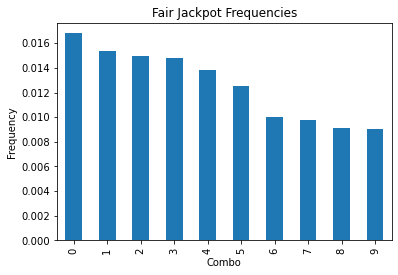

In [6]:
fdf10['freq'].plot.bar(title = 'Fair Jackpot Frequencies', xlabel ='Combo', ylabel='Frequency', legend = False)

<AxesSubplot:title={'center':'Weighted Jackpot Frequencies'}, xlabel='Combo', ylabel='Frequency'>

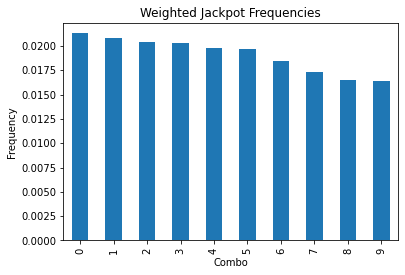

In [7]:
wdf10['freq'].plot.bar(title = 'Weighted Jackpot Frequencies', xlabel ='Combo', ylabel='Frequency', legend = False)

## Scenario 3

In [8]:
atable = pd.read_csv('letter-freqs.csv', names=['Letters','Weights'], sep='\t')
alphabet = FClasses.Die(atable['Letters'])
for i in range(len(atable)):
    alphabet.change_weight(str(atable['Letters'][i]), float(atable['Weights'][i]))

alphagame = FClasses.Game([alphabet, alphabet, alphabet, alphabet, alphabet])
alphagame.play(1000)

alphan = FClasses.Analyzer(alphagame)
alphcombo = alphan.combo()

English-Like Words = 44   
Frequency of Like-Words = 44/996 = 0.04417670682730924

# Directory Listing
A code block that executes the following bash command:   
!ls -lRF -o

In [2]:
!ls -lRF -o

total 216
-rw-r--r--  1 gunnarfranko  23068 Jul 15 11:42 5100Final.ipynb
drwxr-xr-x  7 gunnarfranko    224 Jul 15 11:44 MonteCarlo.egg-info/
-rw-r--r--  1 gunnarfranko    180 Jul 14 18:28 __init__.py
drwxr-xr-x  3 gunnarfranko     96 Jul 15 11:26 __pycache__/
-rw-r--r--  1 gunnarfranko   6188 Jul 14 10:46 montecarlo.py
-rw-r--r--  1 gunnarfranko  54904 Jul 15 11:08 montecarlo_demo.ipynb
-rw-r--r--@ 1 gunnarfranko    781 Jul 14 11:21 montecarlo_test.txt
-rw-r--r--  1 gunnarfranko   4488 Jul 14 10:45 montecarlo_tests.py
-rw-r--r--@ 1 gunnarfranko    473 Jul 15 11:37 setup.py

./MonteCarlo.egg-info:
total 40
-rw-r--r--  1 gunnarfranko  238 Jul 15 11:44 PKG-INFO
-rw-r--r--  1 gunnarfranko  177 Jul 15 11:44 SOURCES.txt
-rw-r--r--  1 gunnarfranko    1 Jul 15 11:44 dependency_links.txt
-rw-r--r--  1 gunnarfranko   32 Jul 15 11:44 requires.txt
-rw-r--r--  1 gunnarfranko    1 Jul 15 11:44 top_level.txt

./__pycache__:
total 16
-rw-r--r--  1 gunnarfranko  6967 Jul 15 11:26 montecarlo.cpython-39.

# Installation Output Listing
A code block that executes the code to install your package and outputs a succesful installation

In [1]:
!pip install -e .

Obtaining file:///Users/gunnarfranko/Downloads/DS%205100/Final%20Project%20
  Running setup.py develop for MonteCarlo
